In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import classification_report
# from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.datasets import fetch_20newsgroups
import os

## Creating new Data set of reviews for Book, Movie and Sport topics

First, handle book reviews from Amazon data set, instead of using full 3 million entries, use 10 thousand, and append them to new data frame where each review can be indicated as book topic.


### Book reviews data

In [3]:
# Load the Books_rating.csv file
import os

# Define the path to your CSV file
books_csv_path = r'c:\Users\augus\university\Text_Mining\final_project\vrije-project-TM\data\topic\Books_rating.csv'

# Check if file exists
if os.path.exists(books_csv_path):
    print(f"✅ File found: {books_csv_path}")
    
    # Load the CSV file into a pandas DataFrame
    books_df = pd.read_csv(books_csv_path)
    
    print(f"\n📊 Dataset loaded successfully!")
    print(f"Shape: {books_df.shape} (rows, columns)")
    
else:
    print(f"❌ File not found: {books_csv_path}")
    print("Let's check what files are available in the data/topic/ directory")

✅ File found: c:\Users\augus\university\Text_Mining\final_project\vrije-project-TM\data\topic\Books_rating.csv

📊 Dataset loaded successfully!
Shape: (3000000, 10) (rows, columns)


In [4]:
# Examine the structure and headers of the dataset
print("📋 COLUMN HEADERS:")
print("=" * 40)
for i, col in enumerate(books_df.columns, 1):
    print(f"{i:2}. {col}")

print(f"\n📈 BASIC INFO:")
print("=" * 40)
print(f"Number of rows: {len(books_df):,}")
print(f"Number of columns: {len(books_df.columns)}")
print(f"Memory usage: {books_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n🔍 DATA TYPES:")
print("=" * 40)
print(books_df.dtypes)

📋 COLUMN HEADERS:
 1. Id
 2. Title
 3. Price
 4. User_id
 5. profileName
 6. review/helpfulness
 7. review/score
 8. review/time
 9. review/summary
10. review/text

📈 BASIC INFO:
Number of rows: 3,000,000
Number of columns: 10
Memory usage: 3679.50 MB

🔍 DATA TYPES:
Id                     object
Title                  object
Price                 float64
User_id                object
profileName            object
review/helpfulness     object
review/score          float64
review/time             int64
review/summary         object
review/text            object
dtype: object


In [6]:
book_topics_df = pd.DataFrame({
    'review_text': books_df['review/text'].iloc[:1197],  # Take first 10k reviews
    'topic': 'book'  # Add 'book' as topic label for all entries
})

book_topics_df = book_topics_df.dropna(subset=['review_text'])


### Movies reviews topic

In [7]:
file_path = '../data/topic/IMDB_Dataset.csv'

movies_df = pd.read_csv(file_path)    

In [8]:
movie_topics_df = pd.DataFrame({
    'review_text': movies_df['review'].iloc[:1197],  # Take first 10k reviews
    'topic': 'movie'
})

movie_topics_df = movie_topics_df.dropna(subset=['review_text'])
# combined_topics_df = pd.concat([book_topics_df, movie_topics_df], ignore_index=True)

# print(combined_topics_df.describe())


### Sports topic

Fetched from scit-learn dataset of newspapers

In [9]:
# Get all available categories first (to confirm sports categories)
all_categories = fetch_20newsgroups().target_names
print("Available categories:")
for i, category in enumerate(all_categories):
    print(f"{i:2d}: {category}")

# Choose only sport categories
sport_categories = ['rec.sport.baseball', 'rec.sport.hockey']
print(f"\nSelected sport categories: {sport_categories}")

# Fetch only the sports data
sports_news = fetch_20newsgroups(subset='train', 
                               categories=sport_categories,
                               remove=('headers', 'footers', 'quotes'),
                               random_state=42)

print(f"\nFetched {len(sports_news.data)} sports articles")

# Create a DataFrame with the same structure as your other topic dataframes
sports_df = pd.DataFrame({
    'review_text': sports_news.data,
    'topic': 'sports'  # All entries labeled as 'sport'
})

# Clean up any empty entries
sports_df = sports_df.dropna(subset=['review_text'])

# Take only the first 10,000 if needed (to match other topics)
if len(sports_df) > 10000:
    sports_df = sports_df.iloc[:10000]

print(f"\nCreated DataFrame with {len(sports_df)} sport articles")
print(sports_df.head(2))

Available categories:
 0: alt.atheism
 1: comp.graphics
 2: comp.os.ms-windows.misc
 3: comp.sys.ibm.pc.hardware
 4: comp.sys.mac.hardware
 5: comp.windows.x
 6: misc.forsale
 7: rec.autos
 8: rec.motorcycles
 9: rec.sport.baseball
10: rec.sport.hockey
11: sci.crypt
12: sci.electronics
13: sci.med
14: sci.space
15: soc.religion.christian
16: talk.politics.guns
17: talk.politics.mideast
18: talk.politics.misc
19: talk.religion.misc

Selected sport categories: ['rec.sport.baseball', 'rec.sport.hockey']

Fetched 1197 sports articles

Created DataFrame with 1197 sport articles
                                         review_text   topic
0  \n\nThe tribe will be in town from April 16 to...  sports
1  This game would have been great as part of a d...  sports


In [10]:
combined_topics_df = pd.concat([book_topics_df, movie_topics_df, sports_df], ignore_index=True)
print(f"\nCombined dataset now has {len(combined_topics_df)} entries")
print(f"Topic distribution:\n{combined_topics_df['topic'].value_counts()}")


Combined dataset now has 3591 entries
Topic distribution:
topic
book      1197
movie     1197
sports    1197
Name: count, dtype: int64


### Saving combined topics dataset

In [11]:
# Define path for saving the combined dataset
output_path = '../data/topic/combined_topics.csv'

# Save the combined DataFrame to CSV
combined_topics_df.to_csv(output_path, index=False)

### Bayes model

In [12]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(combined_topics_df, test_size=0.1, random_state=0,
                               stratify=combined_topics_df[['topic']])

In [13]:
from sklearn import naive_bayes
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

Train_X, y_train = train['review_text'], train['topic']
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(train['review_text'])

Train_X_Tfidf = Tfidf_vect.transform(Train_X)

model = naive_bayes.MultinomialNB()
model.fit(Train_X_Tfidf, y_train)

MultinomialNB()

In [14]:
topic_test_df = pd.read_csv('../data/sentiment-topic-test.tsv', sep='\t')

print(topic_test_df.head())

   sentence_id                                           sentence sentiment  \
0            0  The stadium was alive with the roar of the cro...  positive   
1            1  That last-minute goal had me jumping out of my...  positive   
2            2  I couldn’t put the book down; it swept me into...  positive   
3            3  The story had its moments, though some parts f...   neutral   
4            4  I enjoyed the way the timelines shifted, even ...   neutral   

    topic  
0  sports  
1  sports  
2    book  
3    book  
4    book  


In [15]:
Test_X = topic_test_df['sentence']
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

# Make predictions
predictions = model.predict(Test_X_Tfidf)

print(predictions)

['sports' 'sports' 'book' 'movie' 'movie' 'movie' 'book' 'sports' 'sports'
 'movie' 'book' 'book' 'movie' 'sports' 'sports' 'movie' 'book' 'book']


Accuracy: 0.7778

Classification Report:
              precision    recall  f1-score   support

        book       0.67      0.67      0.67         6
       movie       0.67      0.67      0.67         6
      sports       1.00      1.00      1.00         6

    accuracy                           0.78        18
   macro avg       0.78      0.78      0.78        18
weighted avg       0.78      0.78      0.78        18



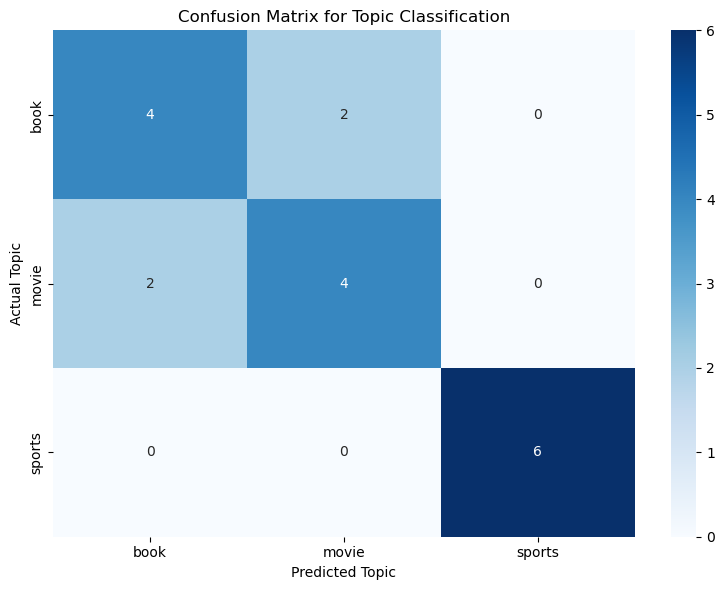


Misclassified examples: 4/18 (22.2%)

Sample of misclassified examples:
                                             sentence  topic predicted_topic
4   I enjoyed the way the timelines shifted, even ...   book           movie
16  It’s surprising how a promising start could un...  movie            book
3   The story had its moments, though some parts f...   book           movie
6   The movie was a wild ride from start to finish...  movie            book


In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Print accuracy
accuracy = accuracy_score(topic_test_df['topic'], predictions)
print(f"Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(topic_test_df['topic'], predictions))

# Create confusion matrix
cm = confusion_matrix(topic_test_df['topic'], predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=model.classes_, 
           yticklabels=model.classes_)
plt.xlabel('Predicted Topic')
plt.ylabel('Actual Topic')
plt.title('Confusion Matrix for Topic Classification')
plt.tight_layout()
plt.show()

# Create a DataFrame with test examples and predictions for analysis
results_df = topic_test_df.copy()
results_df['predicted_topic'] = predictions

# Show misclassified examples
misclassified = results_df[results_df['topic'] != results_df['predicted_topic']]
print(f"\nMisclassified examples: {len(misclassified)}/{len(results_df)} ({len(misclassified)/len(results_df):.1%})")

if len(misclassified) > 0:
    print("\nSample of misclassified examples:")
    sample_size = min(5, len(misclassified))
    print(misclassified[['sentence', 'topic', 'predicted_topic']].sample(sample_size))

### Pytorch neural network model

In [22]:
# PyTorch implementation for text classification
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 1. Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Create and fit label encoder (same as in your XGBoost code)
le = LabelEncoder()
le.fit(y_train)  # Learn mapping from string labels to numbers
y_train_encoded = le.transform(y_train)
num_classes = len(le.classes_)
print(f"Classes: {le.classes_}, Encoded as: {np.unique(y_train_encoded)}")

# 3. Convert sparse TF-IDF matrix to PyTorch tensors
X_train_dense = Train_X_Tfidf.toarray().astype(np.float32)
X_test_dense = Test_X_Tfidf.toarray().astype(np.float32)

X_train_tensor = torch.FloatTensor(X_train_dense).to(device)
y_train_tensor = torch.LongTensor(y_train_encoded).to(device)
X_test_tensor = torch.FloatTensor(X_test_dense).to(device)

# 4. Define neural network model
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=100, num_classes=3):
        super(TextClassifier, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.output_layer = nn.Linear(hidden_dim//2, num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.output_layer(x)

# 5. Initialize model
input_dim = X_train_dense.shape[1]
model = TextClassifier(input_dim, hidden_dim=128, num_classes=num_classes).to(device)
print(f"Model created with input dimension: {input_dim}, output classes: {num_classes}")

# 6. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 7. Training loop
num_epochs = 20
batch_size = 64

# Simple batch creation function
def get_batch(X, y, batch_size, idx):
    start_idx = idx * batch_size
    end_idx = min((idx + 1) * batch_size, len(X))
    return X[start_idx:end_idx], y[start_idx:end_idx]

print("Beginning training...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    num_batches = int(np.ceil(len(X_train_tensor) / batch_size))
    
    for i in range(num_batches):
        # Get batch
        X_batch, y_batch = get_batch(X_train_tensor, y_train_tensor, batch_size, i)
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    # Print progress
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/num_batches:.4f}')

print("Training complete!")

# 8. Evaluate on test data
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, numeric_predictions = torch.max(outputs, 1)
    numeric_predictions = numeric_predictions.cpu().numpy()

# 9. Convert back to original string labels
predictions = le.inverse_transform(numeric_predictions)
print("Predictions complete!")

Using device: cpu
Classes: ['book' 'movie' 'sports'], Encoded as: [0 1 2]
Model created with input dimension: 5000, output classes: 3
Beginning training...
Epoch [2/20], Loss: 0.2630
Epoch [4/20], Loss: 0.0200
Epoch [6/20], Loss: 0.0049
Epoch [8/20], Loss: 0.0023
Epoch [10/20], Loss: 0.0010
Epoch [12/20], Loss: 0.0007
Epoch [14/20], Loss: 0.0004
Epoch [16/20], Loss: 0.0004
Epoch [18/20], Loss: 0.0003
Epoch [20/20], Loss: 0.0002
Training complete!
Predictions complete!


Accuracy: 0.6667

Classification Report:
              precision    recall  f1-score   support

        book       1.00      0.67      0.80         6
       movie       0.50      0.33      0.40         6
      sports       0.60      1.00      0.75         6

    accuracy                           0.67        18
   macro avg       0.70      0.67      0.65        18
weighted avg       0.70      0.67      0.65        18



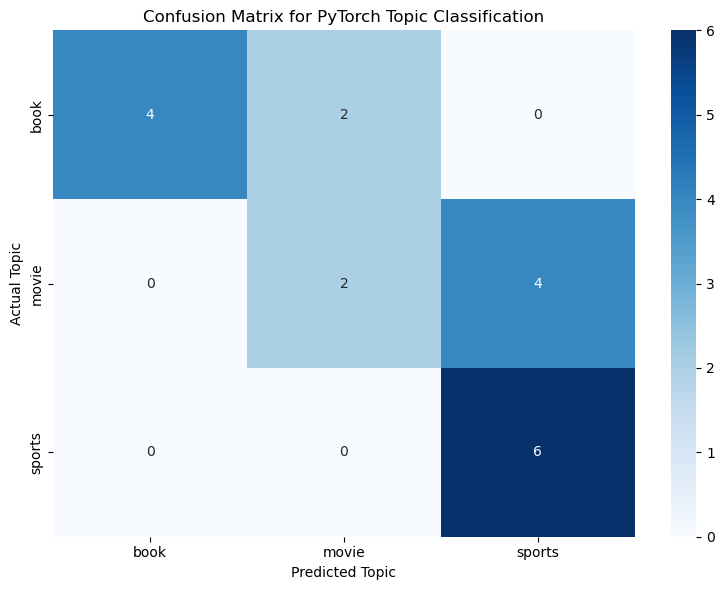


Misclassified examples: 6/18 (33.3%)

Sample of misclassified examples:
                                             sentence  topic predicted_topic
6   The movie was a wild ride from start to finish...  movie          sports
10  I found the main character so annoying that it...   book           movie
15  Word is, the screenplay was scribbled down dur...  movie          sports
16  It’s surprising how a promising start could un...  movie          sports
9   The trailer was decent, giving you a taste wit...  movie          sports


In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Print accuracy
accuracy = accuracy_score(topic_test_df['topic'], predictions)
print(f"Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(topic_test_df['topic'], predictions))

# Create confusion matrix
cm = confusion_matrix(topic_test_df['topic'], predictions)

# Plot confusion matrix 
plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=le.classes_,  # Use LabelEncoder classes instead of model.classes_
           yticklabels=le.classes_)  # Use LabelEncoder classes instead of model.classes_
plt.xlabel('Predicted Topic')
plt.ylabel('Actual Topic')
plt.title('Confusion Matrix for PyTorch Topic Classification')
plt.tight_layout()
plt.show()

# Create a DataFrame with test examples and predictions for analysis
results_df = topic_test_df.copy()
results_df['predicted_topic'] = predictions

# Show misclassified examples
misclassified = results_df[results_df['topic'] != results_df['predicted_topic']]
print(f"\nMisclassified examples: {len(misclassified)}/{len(results_df)} ({len(misclassified)/len(results_df):.1%})")

if len(misclassified) > 0:
    print("\nSample of misclassified examples:")
    sample_size = min(5, len(misclassified))
    print(misclassified[['sentence', 'topic', 'predicted_topic']].sample(sample_size))

### XGB Boost

In [26]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)  # Learn mapping from string labels to numbers

y_train_encoded = le.transform(y_train)

model = xgb.XGBClassifier()
model.fit(Train_X_Tfidf, y_train_encoded)

numeric_predictions = model.predict(Test_X_Tfidf)

predictions = le.inverse_transform(numeric_predictions)


Accuracy: 0.6111

Classification Report:
              precision    recall  f1-score   support

        book       1.00      0.33      0.50         6
       movie       1.00      0.50      0.67         6
      sports       0.46      1.00      0.63         6

    accuracy                           0.61        18
   macro avg       0.82      0.61      0.60        18
weighted avg       0.82      0.61      0.60        18



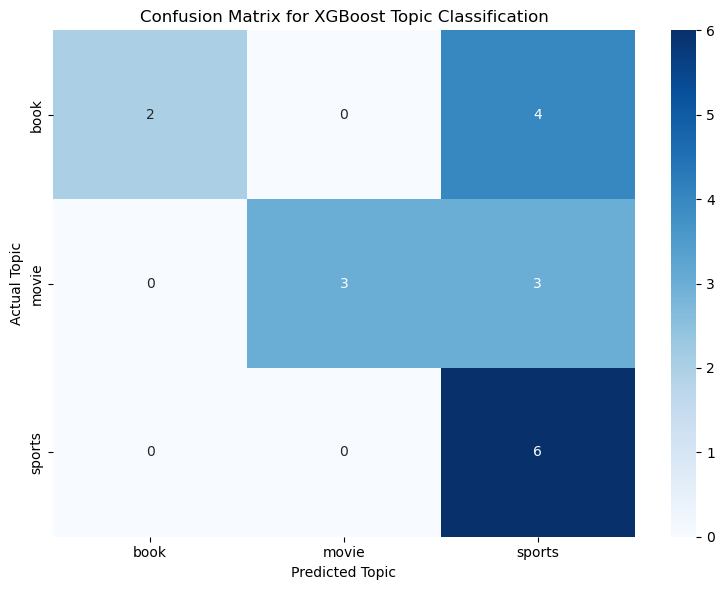


Misclassified examples: 7/18 (38.9%)

Sample of misclassified examples:
                                             sentence  topic predicted_topic
10  I found the main character so annoying that it...   book          sports
3   The story had its moments, though some parts f...   book          sports
4   I enjoyed the way the timelines shifted, even ...   book          sports
11  The author's style feels really genuine, makin...   book          sports
16  It’s surprising how a promising start could un...  movie          sports


In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Print accuracy
accuracy = accuracy_score(topic_test_df['topic'], predictions)
print(f"Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(topic_test_df['topic'], predictions))

# Create confusion matrix
cm = confusion_matrix(topic_test_df['topic'], predictions)

# Plot confusion matrix 
plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=le.classes_,  
           yticklabels=le.classes_)
plt.xlabel('Predicted Topic')
plt.ylabel('Actual Topic')
plt.title('Confusion Matrix for XGBoost Topic Classification')  # Changed to XGBoost
plt.tight_layout()
plt.show()

# Create a DataFrame with test examples and predictions for analysis
results_df = topic_test_df.copy()
results_df['predicted_topic'] = predictions

# Show misclassified examples
misclassified = results_df[results_df['topic'] != results_df['predicted_topic']]
print(f"\nMisclassified examples: {len(misclassified)}/{len(results_df)} ({len(misclassified)/len(results_df):.1%})")

if len(misclassified) > 0:
    print("\nSample of misclassified examples:")
    sample_size = min(5, len(misclassified))
    print(misclassified[['sentence', 'topic', 'predicted_topic']].sample(sample_size))